<a href="https://colab.research.google.com/github/PamelaCarina/bitcoin_prediction/blob/master/prueba1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd 
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
from statsmodels.tsa.stattools import adfuller #test estadístico que se usa para saber si los datos son estacionarios
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA




# Estacionaridad de los datos

In [ ]:
df = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df.dtypes
df.info()
df.describe()
df['Timestamp']=pd.to_datetime(df['Timestamp'], unit='s')
df=df.dropna().reset_index(drop=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243597 entries, 0 to 2243596
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 136.9 MB


In [ ]:
df = df.set_index('Timestamp')
df_day=df.resample('D').mean()
df_day=df_day.dropna().reset_index(drop=True)
df_month=df.resample('M').mean()
df_year=df.resample('Y').mean()
df_quarter=df.resample('Q').mean()

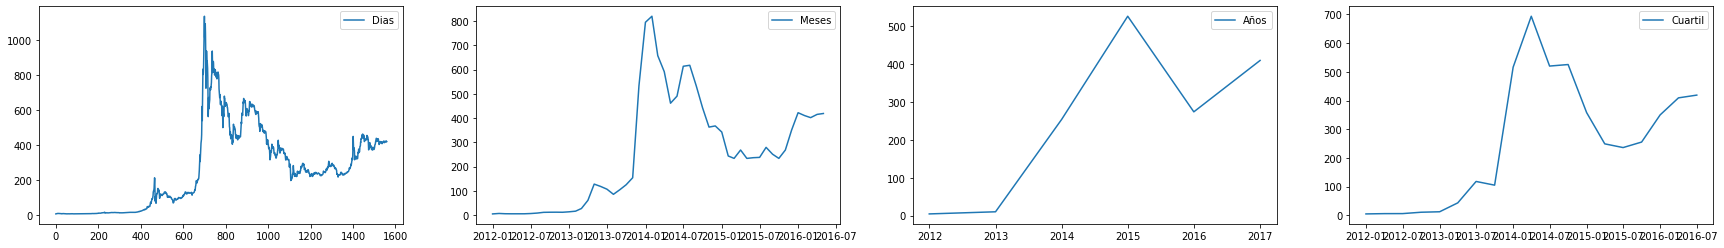

In [ ]:

fig = plt.figure(figsize=[30, 4])
plt.subplot(141)
plt.plot(df_day.Weighted_Price, '-', label='Dias')
plt.legend()

plt.subplot(142)
plt.plot(df_month.Weighted_Price, '-', label='Meses')
plt.legend()

plt.subplot(143)
plt.plot(df_year.Weighted_Price, '-', label='Años')
plt.legend()

plt.subplot(144)
plt.plot(df_quarter.Weighted_Price, '-', label='Cuartil')
plt.legend()

In [ ]:

mes=adfuller(df_month.Weighted_Price)
dia=adfuller(df_day.Weighted_Price)
anio=adfuller(df_year.Weighted_Price)
cuartil=adfuller(df_quarter.Weighted_Price)
print('p-value mes: %f'%mes[1])
print('p-value dia: %f'%dia[1])
print('p-value anio: %f'%anio[1])
print('p-value cuartil: %f'%cuartil[1])

p-value mes: 0.454633
p-value dia: 0.442629
p-value anio: 0.635666
p-value cuartil: 0.000000


In [ ]:
def test_stationarity(x):    
    # Dickey Fuller test    
    result=adfuller(x)
    #print('ADF Stastistic: %f'%result[0])
    print('p-value: %0.6f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("No es estacionario")
            break
         else:
            print("Se rechaza hipotesis nula, dato es estacionario")
            break;


In [ ]:
ts=df
test_stationarity(df_month.Weighted_Price)




p-value: 0.454633
No es estacionario


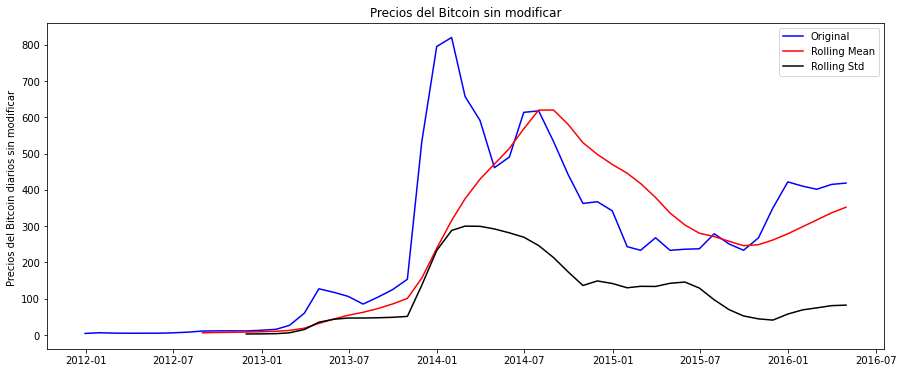

In [ ]:
rolmean = df_month.Weighted_Price.rolling(window=9,center=False).mean()
rolstd = df_month.Weighted_Price.rolling(window=12,center=False).std() 

orig = plt.plot(df_month.Weighted_Price, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')

plt.legend(loc='best')
plt.title('Precios del Bitcoin sin modificar')

plt.ylabel("Precios del Bitcoin diarios sin modificar ")
plt.show(block=False)

In [ ]:
from scipy import stats

#transformada logaritmica de los datos:

ts_logtrsform = np.log(df_month.Weighted_Price)
test_stationarity(ts_logtrsform)
#transformada box_cox:
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
test_stationarity(df_month.Weighted_Price_box)

p-value: 0.536785
No es estacionario
p-value: 0.479832
No es estacionario


In [ ]:
#Diferenciacion seasonal:
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
df_month=df_month.dropna().reset_index(drop=True)
test_stationarity(df_month.prices_box_diff)

p-value: 0.140027
No es estacionario


In [ ]:
#Diferenciacion de primer orden: 

df_month['prices_box_diff2']=df_month.prices_box_diff-df_month.prices_box_diff.shift(1)
df_month=df_month.dropna()
test_stationarity(df_month.prices_box_diff2)
df_month.head()


p-value: 0.001832
Se rechaza hipotesis nula, dato es estacionario


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Weighted_Price_box,prices_box_diff,prices_box_diff2
1,15.806993,15.810590,15.803410,15.807077,25.635318,405.933506,15.806890,4.654129,2.054987,-0.163981
2,26.805557,26.811744,26.798420,26.805076,19.510576,506.798438,26.805143,6.180560,3.939269,1.884281
3,60.496951,60.540215,60.457053,60.498742,13.141915,766.330341,60.495681,9.162611,7.005954,3.066685
4,127.501603,127.730038,127.223951,127.486322,13.728769,1613.402974,127.481485,12.749474,10.589052,3.583099
5,117.820814,117.892933,117.677027,117.759365,8.001642,916.120162,117.780293,12.322643,10.144076,-0.444976


ValueError: ignored

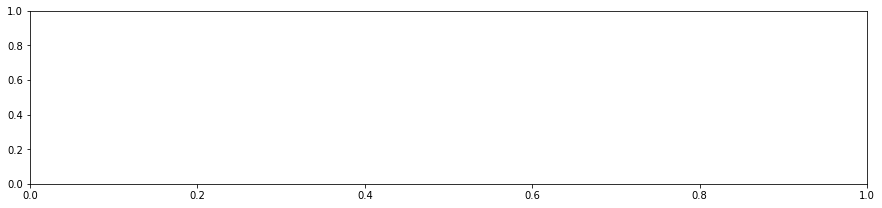

In [ ]:
import statsmodels.api as sm
import statsmodels as sm


#sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
#print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsaplots.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsaplots.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()
